In [7]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint


In [8]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [9]:
# spacy for lemmatization
import spacy

In [10]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

In [12]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [13]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
# NLTK Stop words
# import nltk
# nltk.data.path.append("/home2/artur/artur-ssd.old/nltk_data")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [15]:
# Import Dataset
df = pd.read_json('1w2.json')
df.head()

,"Friends and fellow citizens: I stand before you tonight under indictment for the alleged crime of having voted at the last presidential election, without having a lawful right to vote. It shall be my work this evening to prove to you that in thus voting, I not only committed no crime, but, instead, simply exercised my citizen's rights, guaranteed to me and all United States citizens by the National Constitution, beyond the power of any state to deny."
0,
1,The preamble of the Federal Constitution says:
2,
3,"""We, the people of the United States, in order..."
4,


In [16]:
# Convert to list
data = df.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['[]']


In [17]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[[]]


In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[]


In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# python3 -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [22]:
id2word[0]

'say'

In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.217*"would" + 0.179*"allow" + 0.088*"work" + 0.086*"way" + 0.044*"seem" + '
  '0.027*"simple" + 0.025*"place" + 0.018*"thought" + 0.017*"point" + '
  '0.017*"offer"'),
 (1,
  '0.124*"sex" + 0.091*"power" + 0.074*"mother" + 0.049*"husband" + '
  '0.043*"home" + 0.035*"wealth" + 0.034*"educate" + 0.033*"wife" + '
  '0.031*"remark" + 0.026*"flow"'),
 (2,
  '0.099*"give" + 0.085*"people" + 0.081*"common" + 0.063*"order" + '
  '0.053*"whole" + 0.043*"form" + 0.042*"draw" + 0.035*"provide" + '
  '0.033*"justice" + 0.032*"half"'),
 (3,
  '0.241*"mind" + 0.181*"duty" + 0.102*"think" + 0.053*"could" + 0.052*"first" '
  '+ 0.048*"word" + 0.045*"mean" + 0.033*"free" + 0.010*"begin" + '
  '0.009*"develop"'),
 (4,
  '0.264*"reason" + 0.096*"part" + 0.069*"come" + 0.062*"keep" + '
  '0.060*"rather" + 0.049*"go" + 0.028*"instinct" + 0.020*"throw" + '
  '0.010*"help" + 0.010*"course"'),
 (5,
  '0.158*"still" + 0.140*"find" + 0.086*"thus" + 0.000*"often" + '
  '0.000*"oppression" + 0.000*"exe

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -21.690197410214033

Coherence Score:  0.5172247252721693


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.371249 -0.177877       1        1  14.194374
17    -0.083241  0.173987       2        1   9.967966
3     -0.093002  0.256230       3        1   9.207425
2     -0.068762  0.110032       4        1   8.400781
1     -0.013871 -0.000072       5        1   7.753478
0     -0.029207  0.017996       6        1   7.343906
4      0.025649 -0.024378       7        1   5.833415
7      0.000134 -0.010022       8        1   5.595813
6      0.013495 -0.018472       9        1   5.481335
11     0.018592 -0.021229      10        1   5.421059
16     0.046255 -0.031002      11        1   4.281199
12     0.052394 -0.032593      12        1   3.385190
8      0.056916 -0.032919      13        1   2.724088
9      0.061284 -0.033134      14        1   2.693207
15     0.064613 -0.032236      15        1   2.076544
10     0.061101 -0.032980      16        1   1.990270
5      0.065423 -0.031614      17        1   1.514328
13     0.066235 -0.029986      18        1   1.274143
14     0.063999 -0.025393      19        1   0.464779
19     0.063241 -0.024340      20        1   0.396696, topic_info=                 Term         Freq        Total Category  logprob  loglift
37              woman  2254.000000  2254.000000  Default  30.0000  30.0000
30                man  1190.000000  1190.000000  Default  29.0000  29.0000
45               make   563.000000   563.000000  Default  28.0000  28.0000
331              mind   691.000000   691.000000  Default  27.0000  27.0000
362            reason   479.000000   479.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1654      universally     0.024479     1.862193  Topic20  -8.5224   1.1980
1655          idolize     0.024479     1.862113  Topic20  -8.5224   1.1981
1558    philosophical     0.024479     1.862115  Topic20  -8.5224   1.1981
1658          exclude     0.024479     1.862122  Topic20  -8.5224   1.1981
1657  dispassionately     0.024479     1.862128  Topic20  -8.5224   1.1981

[1001 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
160       9  0.871866     able
348      18  0.715189      aim
366       6  0.995981    allow
395       9  0.932410  ancient
191      16  0.783402   arrive
...     ...       ...      ...
129       3  0.985435     word
236       6  0.991846     work
145       6  0.996550    would
146      15  0.967078    write
384      11  0.971532     year

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 18, 4, 3, 2, 1, 5, 8, 7, 12, 17, 13, 9, 10, 16, 11, 6, 14, 15, 20])

In [27]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.371249 -0.177877       1        1  14.194374
17    -0.083241  0.173987       2        1   9.967966
3     -0.093002  0.256230       3        1   9.207427
2     -0.068762  0.110032       4        1   8.400780
1     -0.013871 -0.000072       5        1   7.753479
0     -0.029207  0.017996       6        1   7.343906
4      0.025649 -0.024378       7        1   5.833415
7      0.000134 -0.010022       8        1   5.595813
6      0.013495 -0.018472       9        1   5.481335
11     0.018592 -0.021229      10        1   5.421059
16     0.046255 -0.031002      11        1   4.281199
12     0.052394 -0.032593      12        1   3.385190
8      0.056916 -0.032919      13        1   2.724088
9      0.061284 -0.033134      14        1   2.693207
15     0.064613 -0.032236      15        1   2.076543
10     0.061101 -0.032980      16        1   1.990270
5      0.065423 -0.031614      17        1   1.514329
13     0.066235 -0.029986      18        1   1.274143
14     0.063999 -0.025393      19        1   0.464779
19     0.063241 -0.024340      20        1   0.396696, topic_info=                 Term         Freq        Total Category  logprob  loglift
37              woman  2254.000000  2254.000000  Default  30.0000  30.0000
30                man  1190.000000  1190.000000  Default  29.0000  29.0000
45               make   563.000000   563.000000  Default  28.0000  28.0000
331              mind   691.000000   691.000000  Default  27.0000  27.0000
362            reason   479.000000   479.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1654      universally     0.024479     1.862193  Topic20  -8.5224   1.1980
1655          idolize     0.024479     1.862113  Topic20  -8.5224   1.1981
1558    philosophical     0.024479     1.862115  Topic20  -8.5224   1.1981
1658          exclude     0.024479     1.862122  Topic20  -8.5224   1.1981
1657  dispassionately     0.024479     1.862128  Topic20  -8.5224   1.1981

[971 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
160       9  0.871866     able
348      18  0.715189      aim
366       6  0.995981    allow
395       9  0.932410  ancient
191      16  0.783402   arrive
...     ...       ...      ...
129       3  0.985435     word
236       6  0.991846     work
145       6  0.996550    would
146      15  0.967078    write
384      11  0.971532     year

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 18, 4, 3, 2, 1, 5, 8, 7, 12, 17, 13, 9, 10, 16, 11, 6, 14, 15, 20])

In [28]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet/'})
mallet_path = 'C:/mallet/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [29]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('reason', 0.17246713070378963),
   ('woman', 0.04021655065738593),
   ('exercise', 0.03248259860788863),
   ('feeling', 0.027842227378190254),
   ('year', 0.027068832173240527),
   ('friendship', 0.02397525135344161),
   ('hold', 0.02088167053364269),
   ('fall', 0.017014694508894045),
   ('fear', 0.017014694508894045),
   ('light', 0.014694508894044857)]),
 (11,
  [('girl', 0.040865384615384616),
   ('moral', 0.03365384615384615),
   ('fact', 0.028846153846153848),
   ('sexual', 0.028044871794871796),
   ('rational', 0.02564102564102564),
   ('boy', 0.022435897435897436),
   ('school', 0.020032051282051284),
   ('draw', 0.019230769230769232),
   ('interest', 0.01842948717948718),
   ('conclusion', 0.016826923076923076)]),
 (10,
  [('life', 0.07976366322008863),
   ('woman', 0.050221565731166914),
   ('good', 0.0413589364844904),
   ('kind', 0.033973412112259974),
   ('effect', 0.03175775480059084),
   ('leave', 0.03175775480059084),
   ('taste', 0.02141802067946824),
   ('mor

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

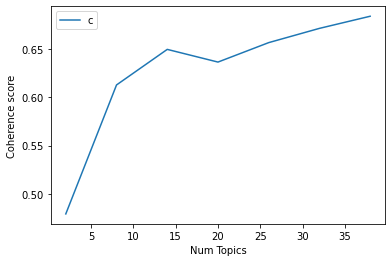

In [32]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.479
Num Topics = 8  has Coherence Value of 0.613
Num Topics = 14  has Coherence Value of 0.65
Num Topics = 20  has Coherence Value of 0.6368
Num Topics = 26  has Coherence Value of 0.657
Num Topics = 32  has Coherence Value of 0.6718
Num Topics = 38  has Coherence Value of 0.6844


In [34]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.136*"woman" + 0.054*"passion" + 0.049*"life" + 0.031*"understand" + '
  '0.029*"chapter" + 0.027*"continue" + 0.027*"animal" + 0.026*"speak" + '
  '0.022*"raise" + 0.020*"write"'),
 (1,
  '0.124*"child" + 0.033*"weakness" + 0.029*"attention" + 0.025*"learn" + '
  '0.024*"kind" + 0.024*"force" + 0.019*"leave" + 0.018*"vanity" + '
  '0.017*"receive" + 0.017*"young"'),
 (2,
  '0.057*"work" + 0.035*"early" + 0.032*"manner" + 0.029*"sexual" + '
  '0.028*"year" + 0.027*"put" + 0.026*"girl" + 0.024*"suppose" + 0.022*"boy" + '
  '0.019*"age"'),
 (3,
  '0.049*"understanding" + 0.042*"feeling" + 0.031*"exercise" + '
  '0.029*"natural" + 0.029*"lose" + 0.028*"part" + 0.024*"back" + '
  '0.023*"dignity" + 0.021*"lead" + 0.020*"seldom"'),
 (4,
  '0.062*"people" + 0.057*"thing" + 0.048*"education" + 0.041*"principle" + '
  '0.037*"truth" + 0.020*"talk" + 0.020*"reputation" + 0.020*"simple" + '
  '0.020*"open" + 0.017*"provide"'),
 (5,
  '0.078*"character" + 0.070*"human" + 0.054*"moral" + 

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[]
1,1,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[The preamble of the Federal Constitution says:]
2,2,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[]
3,3,16.0,0.1269,"woman, form, mankind, ignorance, hold, half, e...","[""We, the people of the United States, in orde..."
4,4,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[]
5,5,16.0,0.2148,"woman, form, mankind, ignorance, hold, half, e...","[It was we, the people; not we, the white male..."
6,6,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[]
7,7,16.0,0.1167,"woman, form, mankind, ignorance, hold, half, e...",[For any state to make sex a qualification tha...
8,8,0.0,0.0500,"woman, passion, life, understand, chapter, con...",[]
9,9,12.0,0.3161,"man, power, find, mother, wife, daughter, imag...",[To them this government has no just powers de...


In [36]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1370,"woman, passion, life, understand, chapter, con...",[sign of food and made ready no doubt for brea...
1,1.0,0.1121,"child, weakness, attention, learn, kind, force...","[children are lavished on the overgrown child,..."
2,2.0,0.1008,"work, early, manner, sexual, year, put, girl, ...","[[This work appeared in 1792, when Talleyrand—..."
3,3.0,0.1163,"understanding, feeling, exercise, natural, los...","[•romantic, wavering feelings—daydreams that r..."
4,4.0,0.1142,"people, thing, education, principle, truth, ta...",[subject merely consists in opening a few simp...


In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"woman, passion, life, understand, chapter, con...",2212.0,0.2459
1.0,0.0,"woman, passion, life, understand, chapter, con...",435.0,0.0483
2.0,0.0,"woman, passion, life, understand, chapter, con...",374.0,0.0416
3.0,16.0,"woman, form, mankind, ignorance, hold, half, e...",439.0,0.0488
4.0,0.0,"woman, passion, life, understand, chapter, con...",436.0,0.0485
...,...,...,...,...
8992.0,3.0,"understanding, feeling, exercise, natural, los...",NaN,NaN
8993.0,0.0,"woman, passion, life, understand, chapter, con...",NaN,NaN
8994.0,0.0,"woman, passion, life, understand, chapter, con...",NaN,NaN
8995.0,0.0,"woman, passion, life, understand, chapter, con...",NaN,NaN
